### Binary decision Memory task
When the cue is presented, return 2 if the value was seen n_back steps before. If not, return 1.

In [82]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import (
    r2_score, 
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss
)
from mlxtend.plotting import plot_confusion_matrix

from echoes import ESNRegressor
import tasks

np.set_printoptions(suppress=True) #prevent numpy exponential 
# Tasks specific params depedning on task choice
trial_params={
    "task_name": 'bin_mem',
    'nr_of_trials': 1_000,
    'trial_length': 20,
    'n_back': 10,
    'trial_matching': True,
    'train_size': 0.8,
}

(X_train, X_test), (y_train, y_test), trials_idx = tasks.create_trials(trial_params)
# np.concatenate((X_train, y_train), axis=1)

y_train = np.roll(X_train[:, 1], trial_params["n_back"])
y_test = np.roll(X_test[:, 1], trial_params["n_back"])

# Transform to multioutput: Encode dummies with -1 instead of 0
#y_train = pd.get_dummies(pd.Series(y_train.flatten())).to_numpy().astype(float)
#y_train[y_train == 0] = -1
#y_train[y_train == 1] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating trials with params:
trial_length: 20
nr_of_trials: 1000
n_back: 10
trial_matching: True
Generating trials with params:
trial_length: 20
nr_of_trials: 1000
n_back: 10
trial_matching: False


In [89]:
%%time
esn = ESNRegressor(
    n_reservoir=200,
    sparsity=.8,
    #input_scaling=10,
    n_transient=200,
).fit(X_train[:, 1].reshape(-1, 1), y_train.reshape(-1, 1))

y_pred = esn.predict(X_test[:,1].reshape(-1, 1))
# Predict and transform prediction into probabilities with softmax
#y_pred = softmax(esn.predict(X_test), axis=1)
#y_pred_classes = y_pred.argmax(axis=1)

CPU times: user 11.6 s, sys: 8.76 s, total: 20.4 s
Wall time: 2.79 s


[[1.         0.84512513]
 [0.84512513 1.        ]]


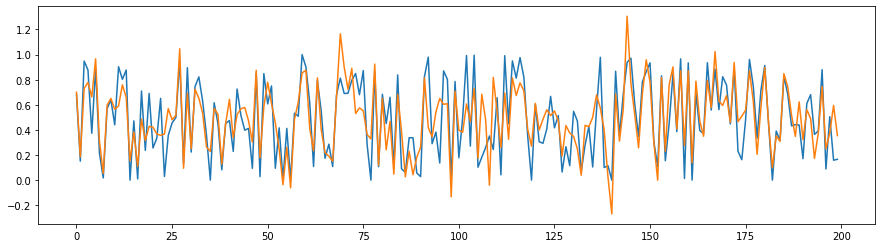

In [90]:
print(np.corrcoef(y_test[100:].flat, y_pred[100:].flat))
plt.figure(figsize=(15, 4))
plt.plot(y_test[100: 300],)
plt.plot(y_pred[100: 300],)

In [63]:
y_pred.shape

(2400, 1)

In [81]:
np.isclose(y_pred[200:].flat, y_test[200:].flat, atol=.01).mean()

1.0

In [60]:
y_

array([[0.        , 0.02903543],
       [0.        , 0.26472962],
       [0.        , 0.39213534],
       ...,
       [0.        , 0.7511261 ],
       [1.        , 0.86182605],
       [0.        , 0.        ]])

In [69]:
# Discard initial transient
#y_test = y_test[500:]
#y_pred = y_pred[500:]
#y_pred_classes = y_pred_classes[500:]
#y_test.shape, y_pred.shape, y_pred_classes.shape

#y_test.shape, y_pred.shape, y_pred_classes.shape

In [70]:
# Remove fixation time and keep only events

print("log loss: ", log_loss(y_test, y_pred), "\n",)

mask = np.where(y_test[:, 0] != 0)
y_test = y_test[mask]
y_pred = y_pred[mask]
y_pred_classes = y_pred_classes[mask]

log loss:  0.37457899788481747 



accuracy:  0.76 
 precision:  [0.79354839 0.73877551] 
 recall:  [0.65775401 0.84976526] 
 f1_score:  [0.71929825 0.79039301]


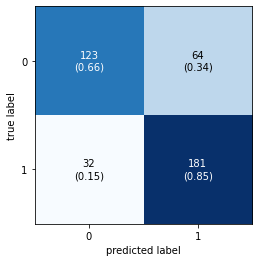

In [71]:
confusion = confusion_matrix(y_test, y_pred_classes)
plot_confusion_matrix(confusion, show_normed=True);

print(
    #"log loss: ", log_loss(y_test, y_pred), "\n",
    "accuracy: ", accuracy_score(y_test, y_pred_classes), "\n",
    "precision: ", precision_score(y_test, y_pred_classes, average=None),"\n",
    "recall: ", recall_score(y_test, y_pred_classes, average=None),"\n",
    "f1_score: ", f1_score(y_test, y_pred_classes, average=None)#average="weighted"),
)   

In [42]:
#log loss:  0.5838217111906386 
#accuracy:  0.9734418604651163 
#precision:  [1.         0.75289575 0.67826825] 
#recall:  [1.         0.60684647 0.80625631] 
#f1_score:  [1.         0.67202757 0.73674504]

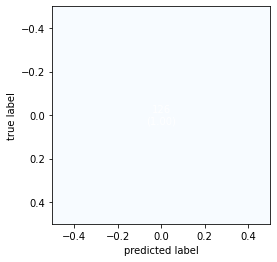

In [16]:
plot_confusion_matrix(confusion[1:, 1:], show_normed=True);

In [17]:
#errors = [
#    error_idx 
#    for error_idx in np.where(y_pred_classes != y_test.flatten())[0]
#    if y_test[error_idx] == 2
#]

#for error in errors:
    #print(np.hstack((X_test[error-5: error+5], y_test[error-5: error+5])))
#    print(y_pred[error-5: error+5])

In [18]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier().fit(X_train, y_train.argmax(axis=1))
dummy_pred = dummy.predict_proba(X_test)
dummy.score(X_test, y_test)

/media/fabrizio/91114856-a405-4086-bfbb-6c0bb5854f13/fdamicel/miniconda3/envs/venvpy38/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


ValueError: Found input variables with inconsistent numbers of samples: [400, 2400]